In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from darts import TimeSeries
from darts.metrics import mae, rmse
from darts.models import RNNModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Auxiliar functions
from tshelpers.plot import plot_compare
from tshelpers.metrics import mae_score, rmse_score

warnings.filterwarnings("ignore", category=UserWarning)
sns.set_theme(style="ticks", palette="mako")

/home/erich/projects/Air-We-Breath/.awb/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reading short imputed master dataframe
master_df = pd.read_csv("data/2016_2021_master_df_short_imputed.csv")
master_df["DATE_PST"] = pd.to_datetime(master_df["DATE_PST"])
master_df.set_index("DATE_PST", inplace=True)
display(master_df.head())
print(master_df.shape)

,STATION,PM 2.5,MISSING,MISSING_SEQ,MISSING_SAMPLE
DATE_PST,,,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0,0,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0,0,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0,0,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0,0,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0,0,0


(228056, 5)


In [3]:
# Redefining experimentation subsets to 2 months prior training set
stations = master_df["STATION"].unique()
subsets = {}
for station in stations:
    subsets[station] = {}
    for month, year in [(2, 2016), (11, 2017), (10, 2018), (8, 2020)]:
        subsets[station][f"{month}-{year}"] = master_df[master_df["STATION"] == station].loc[
    datetime(year, month-1, 1):datetime(year, month+1, 1), ["PM 2.5"]]

for station in subsets:
    print(station, subsets[station].keys())

# Darts timeseries64
for station in subsets:
    for month in subsets[station]:
        subsets[station][month] = TimeSeries.from_dataframe(subsets[station][month])

Vancouver_Clark_Drive_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
Vancouver_International_Airport_#2_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
North_Vancouver_Mahon_Park_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
North_Vancouver_Second_Narrows_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])


In [4]:
station_subset = master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"]
subset = station_subset.loc[datetime(2020, 7, 1):datetime(2020, 9, 1), "PM 2.5"]
series = TimeSeries.from_dataframe(subset.to_frame().interpolate())

train, val = series.split_before(pd.Timestamp(datetime(2020, 8, 15)))

## Creating month, year, and day-of-week covariates
# Year covariates
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(),
                    freq=series.freq_str,
                    periods=len(series)),
    attribute="year",
    one_hot=False,
)

In [5]:
# Past covariates
past_covariates = {}
for year in [2016, 2017, 2018, 2019]:
    past_covariates[year] = station_subset.loc[datetime(year, 7, 1):datetime(year, 9, 1), "PM 2.5"]
    past_covariates[year] = TimeSeries.from_dataframe(past_covariates[year].to_frame().interpolate())

## Past Covariates
Investigating influence of past covariates on training

In [6]:
# LSTM with previous year covariates
start_date = datetime(2020, 7, 1)   # Subset start date
end_date = datetime(2020, 9, 1)     # Subset end date
split_date = datetime(2020, 8, 15)  # Training/Validation split date

results_dict = {}

station_subset = master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"]
subset = station_subset.loc[start_date:end_date, "PM 2.5"]
series = TimeSeries.from_dataframe(subset.to_frame().interpolate())

train, val = series.split_before(pd.Timestamp(split_date))

## Creating month, day-of-week, and hour covariates
# Month covariates
month_series = datetime_attribute_timeseries(
    series, attribute="month", one_hot=True
)

# Weekday covariates
weekday_series = datetime_attribute_timeseries(
    series, attribute="weekday", one_hot=True
)

# Hour covariates
hour_series = datetime_attribute_timeseries(
    series, attribute="hour", one_hot=False
)
# Scaling hour covariates
hour_series = Scaler().fit_transform(hour_series)

# Stacking covariates
covariates = month_series.stack(weekday_series)
covariates = covariates.stack(hour_series)

## Creating previous years covariates
past_covariates = {}
for year in [2019, 2018, 2017, 2016]:
    past_covariates[year] = station_subset.loc[datetime(year, 7, 1):datetime(year, 9, 1), "PM 2.5"]
    print(f"Missing values on {year} covariate: {past_covariates[year].to_frame().isna().sum()}")
    past_covariates[year] = TimeSeries.from_dataframe(past_covariates[year].to_frame().interpolate())

    print(f"Concatenating past covariate for year {year}...")
    past_covariates[year] = covariates.concatenate(past_covariates[year], axis=1, ignore_time_axis=True)
    # cov_train, cov_val = past_covariates[year].split_before(pd.Timestamp(split_date))

    model_name = f"LSTM_2020_{year}"
    results_dict[model_name] = {}

    # Early stopping
    stopper = EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=0.02,
        mode="min"
    )

    # LSTM model
    my_model = RNNModel(
        model="LSTM",
        hidden_dim=200,
        dropout=0.1,
        batch_size=32,
        n_epochs=100,
        optimizer_kwargs={"lr": 5e-4},
        model_name=model_name,
        log_tensorboard=True,
        random_state=123,
        training_length=20,
        input_chunk_length=21,
        force_reset=True,
        save_checkpoints=True,
        pl_trainer_kwargs={
            "callbacks": [stopper],
            "accelerator": "gpu",
            "devices": -1,
            "auto_select_gpus": True
        }
    )

    # Training
    my_model.fit(
        train,
        future_covariates=past_covariates[year],
        val_series=val,
        val_future_covariates=past_covariates[year],
        verbose=True,
    )

    # Validation
    pred_val = my_model.predict(n=len(val), future_covariates=past_covariates[year])
    my_model.load_from_checkpoint(model_name=model_name, best=True)

    # Storing results
    results_dict[model_name]["best_model"] = my_model
    results_dict[model_name]["covariates"] = past_covariates[year]
    results_dict[model_name]["train"] = train
    results_dict[model_name]["val"] = val
    results_dict[model_name]["pred_val"] = pred_val
    results_dict[model_name]["MAE"] = mae(pred_val, val)
    results_dict[model_name]["RMSE"] = rmse(pred_val, val)

Missing values on 2019 covariate: PM 2.5    16
dtype: int64
Concatenating past covariate for year 2019...


2022-11-28 00:25:49 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]
2022-11-28 00:25:49 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-28 00:25:49 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-28 00:25:49 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-28 00:25:49 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-28 00:25:55 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-28 00:25:55 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 179 K 
4 | V             | Linear    

Epoch 27: 100%|██████████| 47/47 [00:00<00:00, 47.52it/s, loss=1.77, v_num=logs, train_loss=1.620, val_loss=4.270]


2022-11-28 00:26:28 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]
Missing values on 2018 covariate: PM 2.5    3
dtype: int64
Concatenating past covariate for year 2018...

2022-11-28 00:26:28 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]


2022-11-28 00:26:28 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-28 00:26:28 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-28 00:26:28 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-28 00:26:28 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-28 00:26:28 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-28 00:26:28 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 179 K 
4 | V             | Linear           | 201   
---------------------------------------------------
179 K     Trainable params
0         No

Epoch 30: 100%|██████████| 47/47 [00:00<00:00, 48.58it/s, loss=1.78, v_num=logs, train_loss=2.580, val_loss=4.900]


2022-11-28 00:27:04 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]
Missing values on 2017 covariate: PM 2.5    17
dtype: int64
Concatenating past covariate for year 2017...


2022-11-28 00:27:04 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]
2022-11-28 00:27:04 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-28 00:27:04 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-28 00:27:04 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-28 00:27:04 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-28 00:27:04 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-28 00:27:04 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 179 K 
4 | V             | Linear    

Epoch 26: 100%|██████████| 47/47 [00:00<00:00, 49.14it/s, loss=1.87, v_num=logs, train_loss=2.560, val_loss=4.300]


2022-11-28 00:27:32 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]
Missing values on 2016 covariate: PM 2.5    26
dtype: int64
Concatenating past covariate for year 2016...


2022-11-28 00:27:33 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]
2022-11-28 00:27:33 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-28 00:27:33 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-28 00:27:33 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-28 00:27:33 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-28 00:27:33 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-28 00:27:33 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 179 K 
4 | V             | Linear    

Epoch 29: 100%|██████████| 47/47 [00:00<00:00, 49.65it/s, loss=1.77, v_num=logs, train_loss=1.410, val_loss=4.250]


2022-11-28 00:28:03 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


Plots for model: LSTM_2020_2019


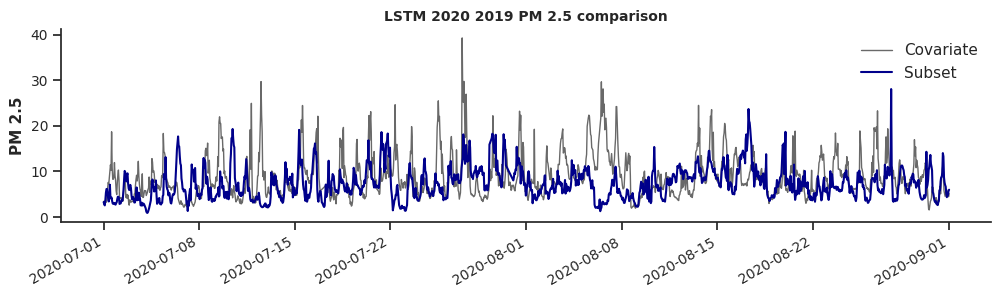

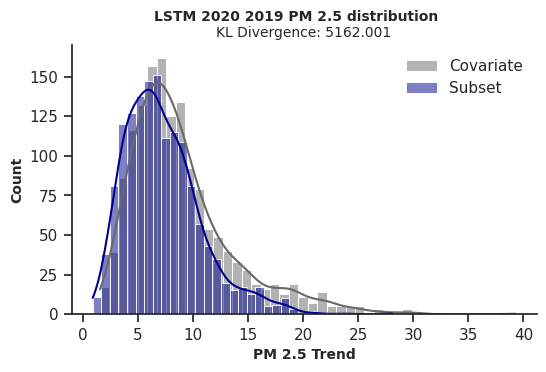

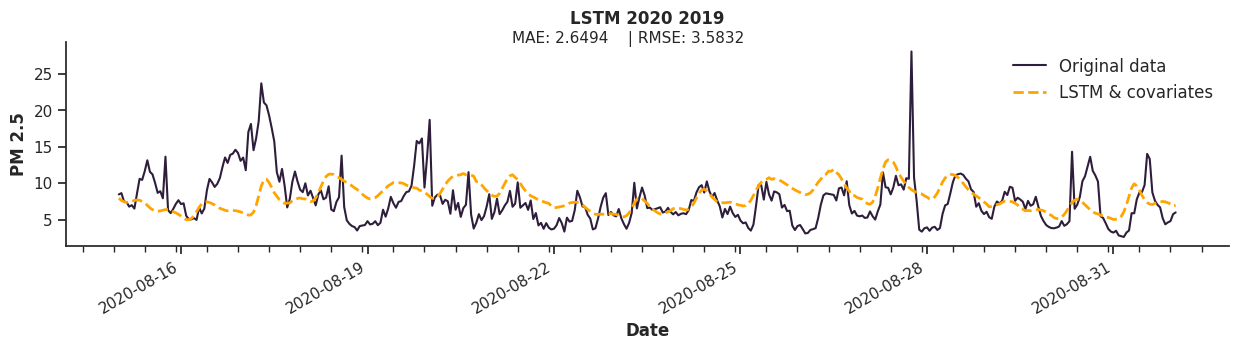

Plots for model: LSTM_2020_2018


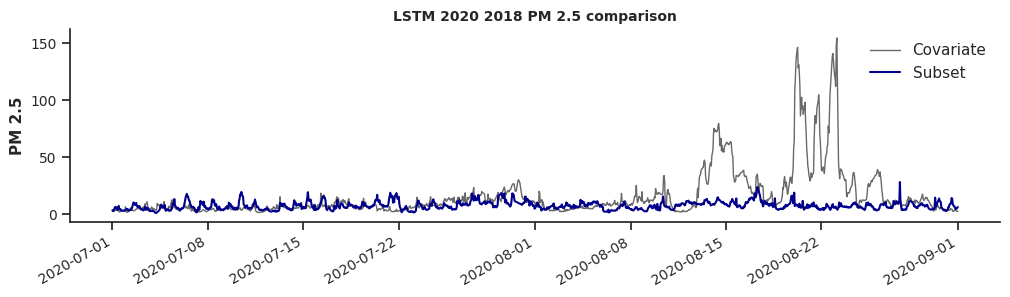

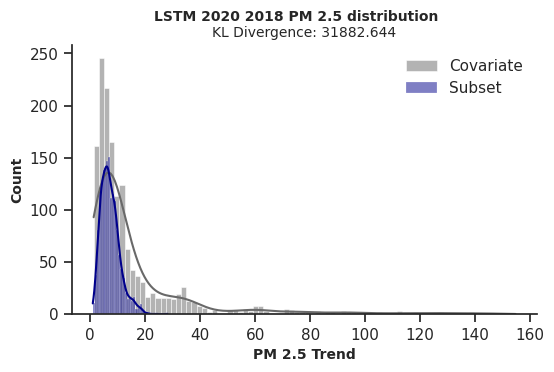

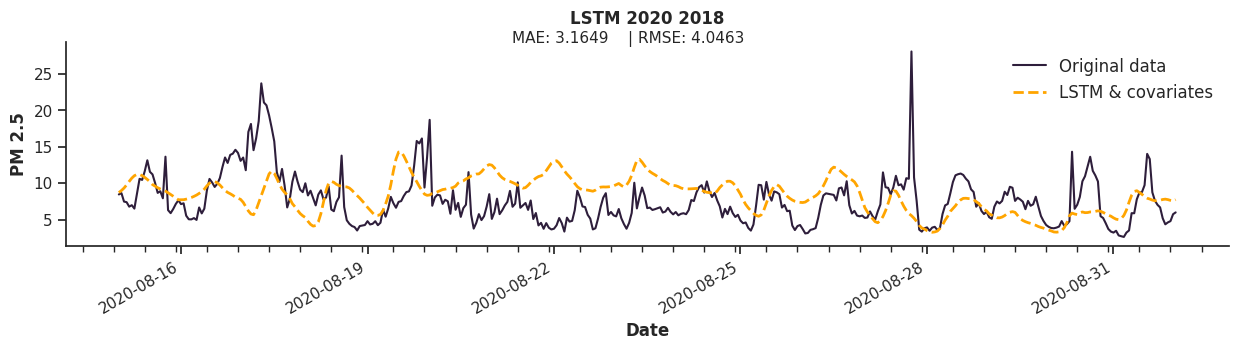

Plots for model: LSTM_2020_2017


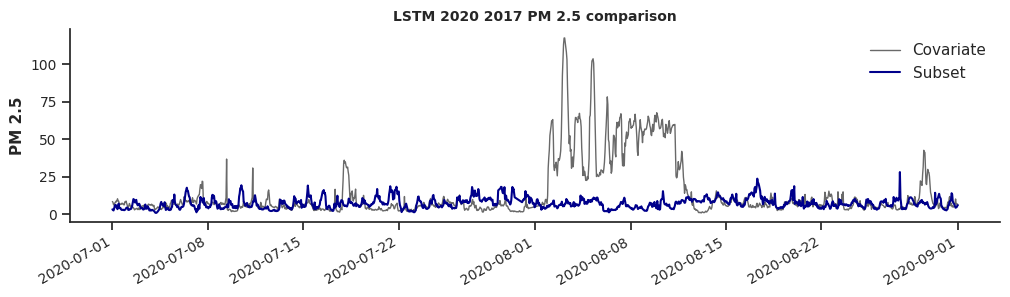

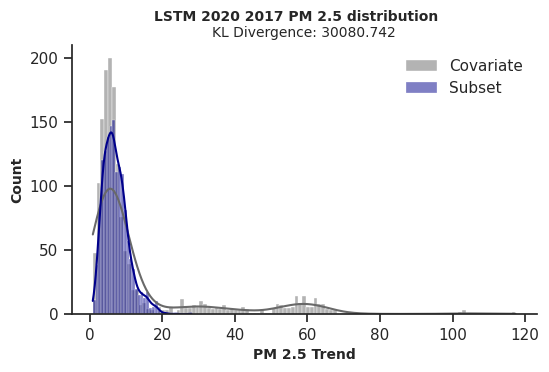

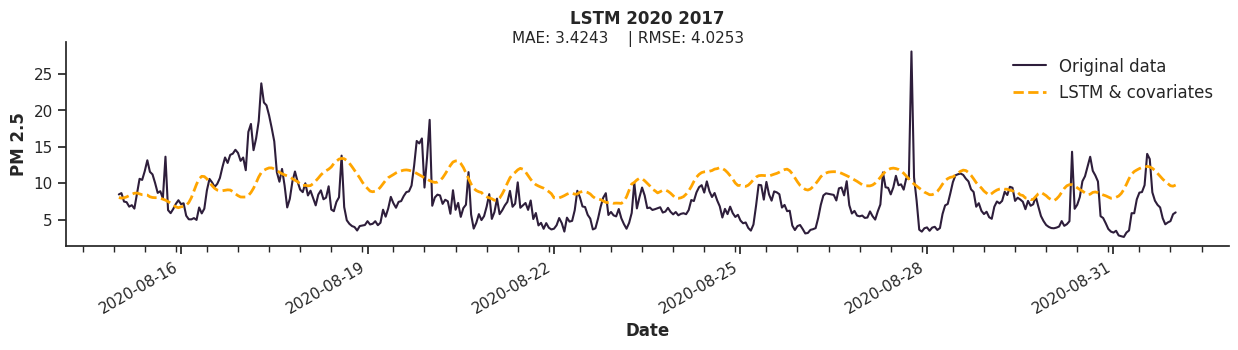

Plots for model: LSTM_2020_2016


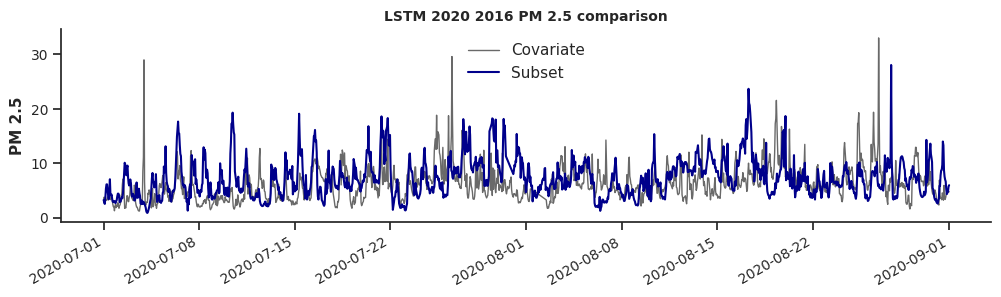

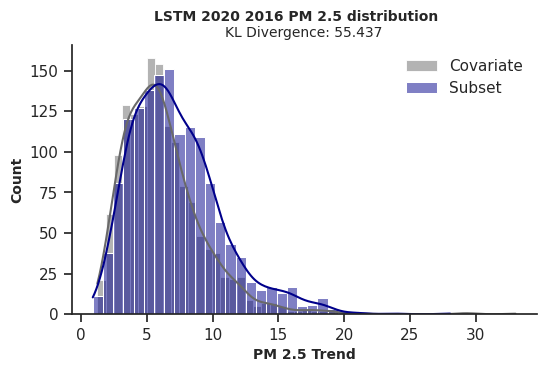

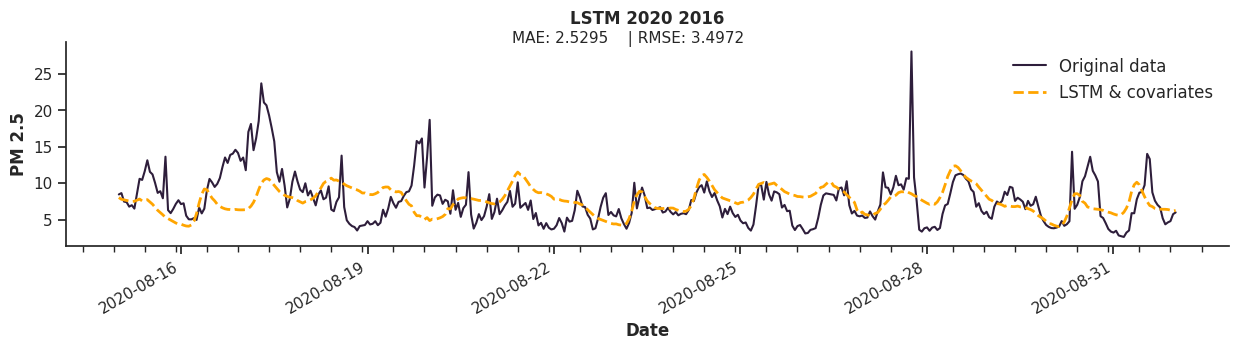

In [7]:
# Plotting results with past year covariates
from scipy.special import rel_entr

for model in results_dict.keys():
    val = results_dict[model]["val"]
    pred_val = results_dict[model]["pred_val"]

    val_df = pd.DataFrame({"DATE_PST": val.time_index, "PM 2.5": [i[0] for i in val.values()]}).set_index("DATE_PST", drop=True)
    pred_df = pd.DataFrame({"DATE_PST": pred_val.time_index, "PM 2.5": [i[0] for i in pred_val.values()]}).set_index("DATE_PST", drop=True)

    # Last column covariate
    last_cov_name = results_dict[model]["covariates"].columns[-1]
    last_cov = results_dict[model]["covariates"][last_cov_name]
    last_cov_df = last_cov[last_cov_name].pd_dataframe()

    print(f"Plots for model: {model}")

    plt.figure(figsize=(12, 2.5))
    last_cov.plot(label="Covariate", linewidth=1, color="dimgray")
    series.plot(label="Subset", linewidth=1.5, color="darkblue")
    plt.title(f'{str(model).replace("_", " ")} PM 2.5 comparison', fontsize=10, fontweight="bold")
    plt.legend()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel("PM 2.5", fontsize=11)
    plt.xlabel("")
    sns.despine()
    plt.show()

    # KL Divergence
    KL_Div = sum(rel_entr(last_cov_df[last_cov_name], subset.interpolate()))

    plt.figure(figsize=(6, 3.5))
    sns.histplot(last_cov_df[last_cov_name], label="Covariate", kde=True, color="dimgray")
    sns.histplot(subset, label="Subset", kde=True, color="darkblue")
    plt.suptitle(f'{str(model).replace("_", " ")} PM 2.5 distribution', fontsize=10, fontweight="bold")
    plt.title(f"KL Divergence: {KL_Div:.3f}", fontsize=10)
    plt.xlabel("PM 2.5 Trend", fontsize=10)
    plt.ylabel("Count", fontsize=10)
    plt.legend()
    sns.despine()
    plt.show()

    plot_compare(
        pred_df,
        val_df,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=False,
        fill=False,
        data_label="LSTM & covariates",
        data_missing_label="Original data",
        plot_title=str(model).replace("_", " "),
        plot_sup_title=f"MAE: {mae_score(val_df, pred_df, value='PM 2.5', verbose=False):.4f}\
    | RMSE: {rmse_score(val_df, pred_df, value='PM 2.5', verbose=False):.4f}",
        figsize=(15, 3)
)

### XGBoost Meta Learner

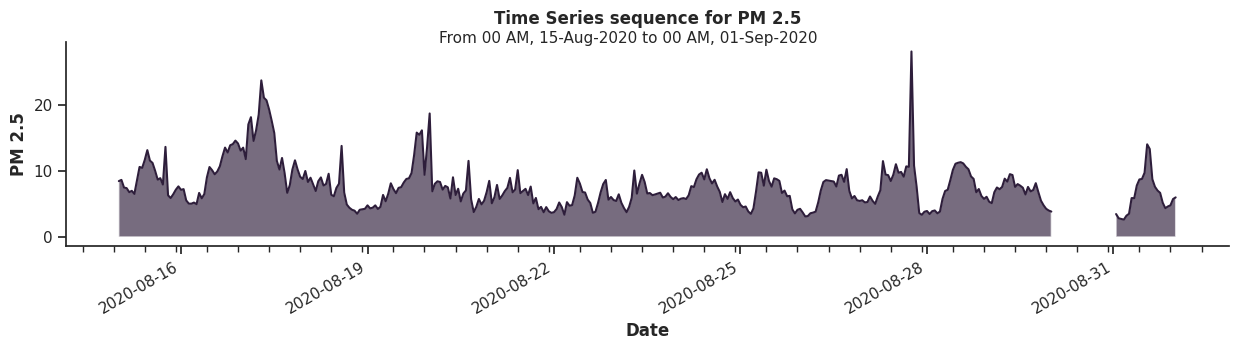

In [8]:
from tshelpers.subset import create_missing
from tshelpers.plot import plot_sequence

# Artificial missing values on validation set
_, val_missing = create_missing(
    data=val_df,
    value="PM 2.5",
    missing_length=24,
    padding=24,
    missing_index="end",
)

plot_sequence(val_missing, value="PM 2.5", figsize=(15, 3))

In [9]:
# Creating feature dataset with LSTM-covariates predictions
try:
    del(stacked_predictions)
except NameError:
    pass

for model_name in results_dict.keys():
    try:
        stacked_predictions = pd.concat([stacked_predictions,
            results_dict[model_name]["pred_val"]\
                .pd_dataframe()\
                .rename(columns={"PM 2.5": model_name[-4:]})],
            axis=1)
    except NameError:
        stacked_predictions = results_dict[model_name]["pred_val"]\
                .pd_dataframe()\
                .copy()\
                .rename(columns={"PM 2.5": model_name[-4:]})

stacked_predictions.head()

component,2019,2018,2017,2016
DATE_PST,,,,
2020-08-15 00:00:00,7.930510,8.700882,8.013677,8.014734
2020-08-15 01:00:00,7.619517,8.982179,7.938530,7.780489
2020-08-15 02:00:00,7.437261,9.322188,7.989900,7.697314
2020-08-15 03:00:00,7.356450,9.752913,8.106971,7.609502
2020-08-15 04:00:00,7.405248,10.232657,8.289606,7.544026


In [10]:
# XGBoost train/test sets

# Training feature is the prediction made by LSTM model of non-missing data
X_train = stacked_predictions.loc[~val_missing["PM 2.5"].isna()]
# Training label is the actual PM 2.5 values of non-missing 
y_train = val_missing.loc[~val_missing["PM 2.5"].isna()]

# Test feature is the prediction made by LSTM of missing data
X_test = stacked_predictions.loc[val_missing["PM 2.5"].isna()]
# Test label is the actual PM 2.5 values of missing data
y_test = val_df.loc[val_missing["PM 2.5"].isna()]

print(f"Training set shape X: {X_train.shape} y: {y_train.shape}")
print(f"Test set shape X: {X_test.shape} y: {y_test.shape}")

Training set shape X: (385, 4) y: (385, 1)
Test set shape X: (24, 4) y: (24, 1)


In [11]:
X_train.head()

component,2019,2018,2017,2016
DATE_PST,,,,
2020-08-15 00:00:00,7.930510,8.700882,8.013677,8.014734
2020-08-15 01:00:00,7.619517,8.982179,7.938530,7.780489
2020-08-15 02:00:00,7.437261,9.322188,7.989900,7.697314
2020-08-15 03:00:00,7.356450,9.752913,8.106971,7.609502
2020-08-15 04:00:00,7.405248,10.232657,8.289606,7.544026


In [12]:
y_train.head()

,PM 2.5
DATE_PST,
2020-08-15 00:00:00,8.446464
2020-08-15 01:00:00,8.628224
2020-08-15 02:00:00,7.467233
2020-08-15 03:00:00,7.384645
2020-08-15 04:00:00,6.770722


In [13]:
X_test.head()

component,2019,2018,2017,2016
DATE_PST,,,,
2020-08-30 01:00:00,5.277769,3.294926,7.587454,4.219649
2020-08-30 02:00:00,5.132960,3.269752,7.832119,4.099971
2020-08-30 03:00:00,5.146549,3.314910,8.213343,4.030542
2020-08-30 04:00:00,5.337100,3.481987,8.738374,4.203521
2020-08-30 05:00:00,5.704566,3.888962,9.269424,4.689611


In [14]:
y_test.head()

,PM 2.5
DATE_PST,
2020-08-30 01:00:00,3.803819
2020-08-30 02:00:00,3.894617
2020-08-30 03:00:00,4.044325
2020-08-30 04:00:00,4.791439
2020-08-30 05:00:00,4.141128


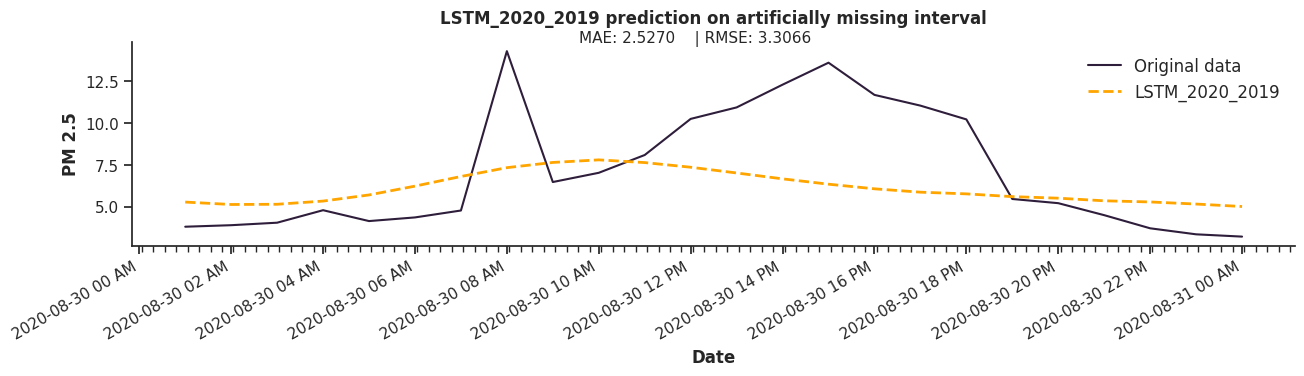

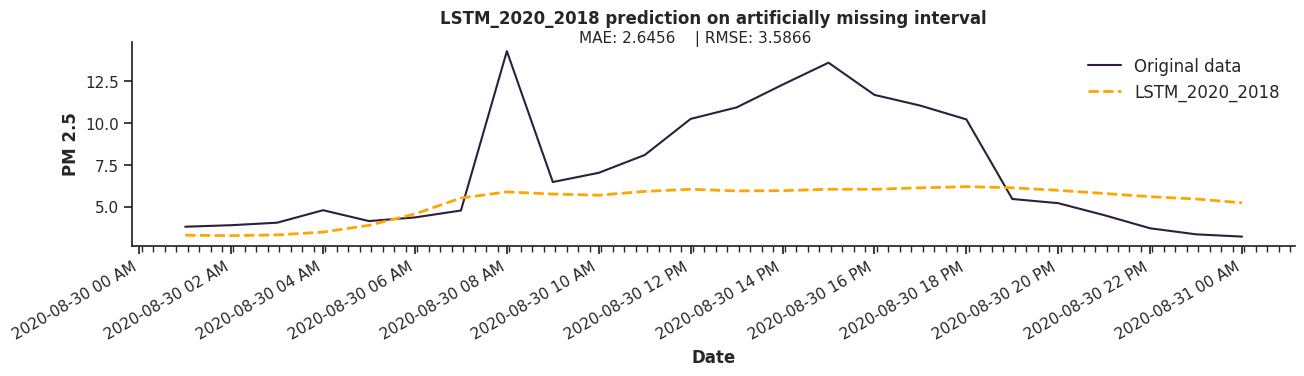

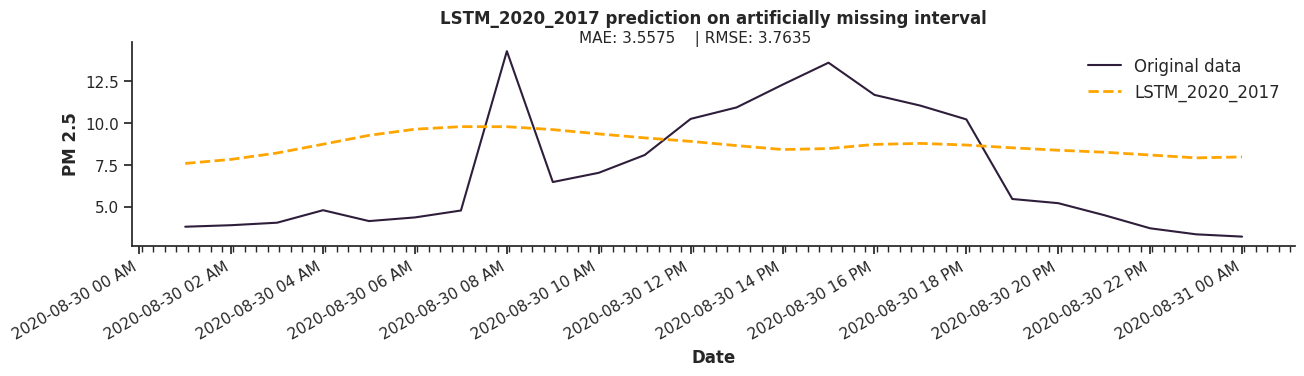

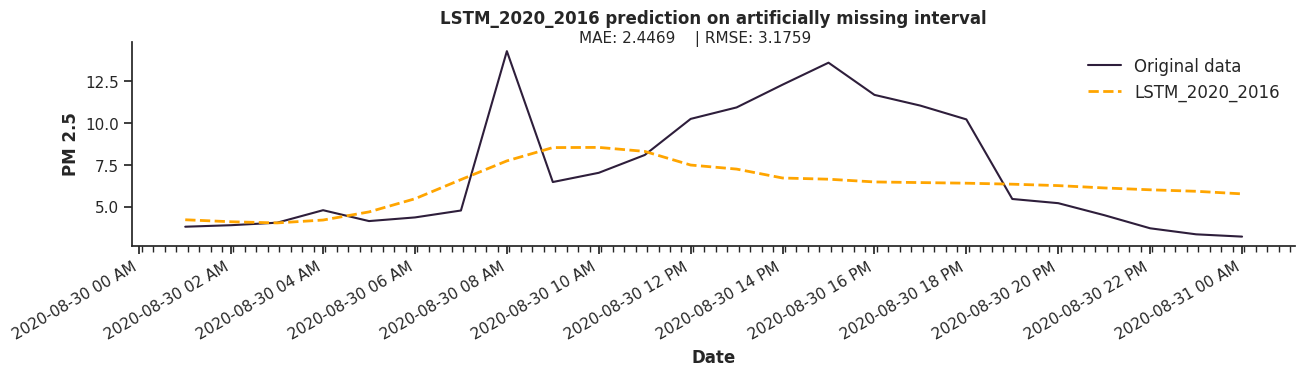

In [15]:
for model_name in results_dict.keys():
    lstm_pred = results_dict[model_name]["pred_val"].pd_dataframe().loc[val_missing["PM 2.5"].isna()]
    plot_compare(
        lstm_pred,
        y_test,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=False,
        fill=False,
        data_label=f"{model_name}",
        data_missing_label="Original data",
        plot_title=f"{model_name} prediction on artificially missing interval",
        plot_sup_title=f"MAE: {np.mean(np.abs(lstm_pred['PM 2.5'] - y_test['PM 2.5'])):.4f}\
    | RMSE: {np.sqrt(np.mean((lstm_pred['PM 2.5'] - y_test['PM 2.5']) ** 2)):.4f}",
        figsize=(15, 3)
    )

In [16]:
import xgboost as xgb
from xgboost import plot_importance

reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       learning_rate=0.005)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=50)

[0]	validation_0-rmse:7.88671	validation_1-rmse:7.49817
[50]	validation_0-rmse:6.38609	validation_1-rmse:6.07903
[100]	validation_0-rmse:5.22395	validation_1-rmse:5.04330
[150]	validation_0-rmse:4.31612	validation_1-rmse:4.27629
[200]	validation_0-rmse:3.61030	validation_1-rmse:3.78304
[250]	validation_0-rmse:3.05876	validation_1-rmse:3.45248
[300]	validation_0-rmse:2.62425	validation_1-rmse:3.26498
[350]	validation_0-rmse:2.28561	validation_1-rmse:3.13428
[400]	validation_0-rmse:2.01542	validation_1-rmse:3.05907
[450]	validation_0-rmse:1.80317	validation_1-rmse:3.01959
[500]	validation_0-rmse:1.62751	validation_1-rmse:2.98182
[550]	validation_0-rmse:1.50318	validation_1-rmse:2.96343
[600]	validation_0-rmse:1.40733	validation_1-rmse:2.93266
[650]	validation_0-rmse:1.31696	validation_1-rmse:2.92784
[700]	validation_0-rmse:1.24047	validation_1-rmse:2.94758
[710]	validation_0-rmse:1.22643	validation_1-rmse:2.95457


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.005, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

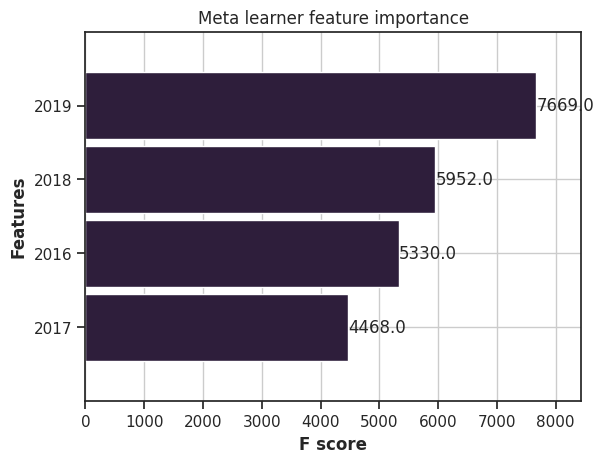

In [17]:
plot_importance(reg, height=0.9, title="Meta learner feature importance")
plt.show()

In [18]:
# XGBoost predictions on training and test sets
X_train["Predicted"] = reg.predict(X_train)
X_test["Predicted"] = reg.predict(X_test)

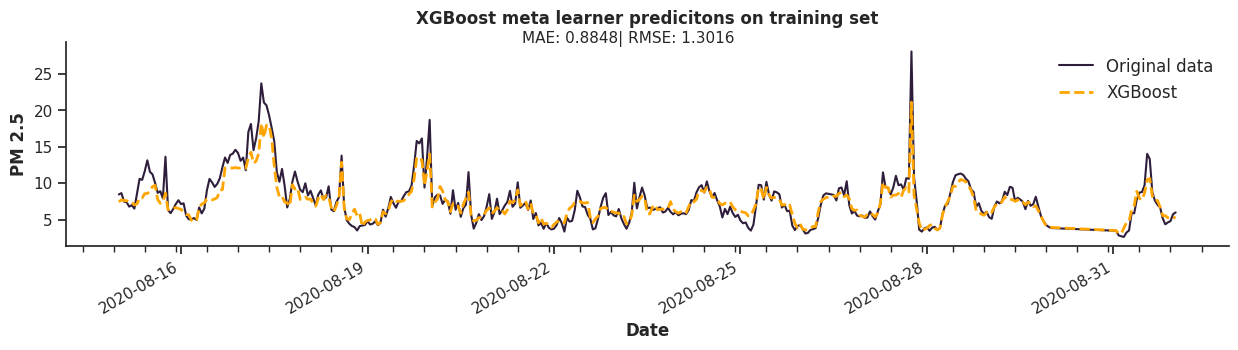

In [19]:
plot_compare(
    X_train,
    y_train,
    value="Predicted",
    value_missing="PM 2.5",
    missing_only=False,
    fill=False,
    data_label="XGBoost",
    data_missing_label="Original data",
    plot_title="XGBoost meta learner predicitons on training set",
    plot_sup_title=f"MAE: {np.mean(np.abs(X_train['Predicted'] - y_train['PM 2.5'])):.4f}\
| RMSE: {np.sqrt(np.mean((X_train['Predicted'] - y_train['PM 2.5']) ** 2)):.4f}",
    figsize=(15, 3)
)

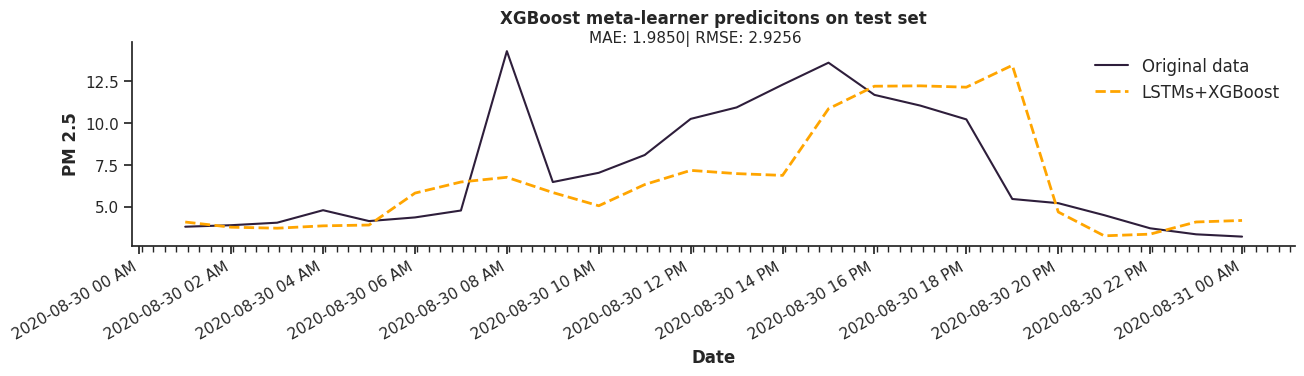

In [20]:
plot_compare(
    X_test,
    y_test,
    value="Predicted",
    value_missing="PM 2.5",
    missing_only=False,
    fill=False,
    data_label="LSTMs+XGBoost",
    data_missing_label="Original data",
    plot_title="XGBoost meta-learner predicitons on test set",
    plot_sup_title=f"MAE: {np.mean(np.abs(X_test['Predicted'] - y_test['PM 2.5'])):.4f}\
| RMSE: {np.sqrt(np.mean((X_test['Predicted'] - y_test['PM 2.5']) ** 2)):.4f}",
    figsize=(15, 3)
)

## Iterating through experimentation subsets
Filtering past covariates on KL Divergence threshold

In [145]:
stations = master_df["STATION"].unique()
stations

array(['Vancouver_Clark_Drive_PM25',
       'Vancouver_International_Airport_#2_PM25',
       'North_Vancouver_Mahon_Park_PM25',
       'North_Vancouver_Second_Narrows_PM25'], dtype=object)

In [147]:
# Experimentation subsets
subsets = {}
for station in stations:
    subsets[station] = {}
    for month, year in [(2, 2016), (11, 2017), (10, 2018), (8, 2020)]:
        subsets[station][f"{month}-{year}"] = master_df[master_df["STATION"] == station].loc[
    datetime(year, month-1, 1):datetime(year, month+1, 1), ["PM 2.5"]]

for station in subsets:
    print(station, subsets[station].keys())

# Darts timeseries64
for station in subsets:
    for month in subsets[station]:
        subsets[station][month] = TimeSeries.from_dataframe(subsets[station][month].interpolate())

Vancouver_Clark_Drive_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
Vancouver_International_Airport_#2_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
North_Vancouver_Mahon_Park_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
North_Vancouver_Second_Narrows_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])


In [148]:
# Auxiliar plotting function
def dart_plot(train, val, station, month, pred=None, pred_label="predicted"):
    plt.figure(figsize=(12, 2.5))
    train.plot(label="training")
    val.plot(label="validation", linewidth=1, color="darkblue")
    if pred:
        pred.plot(label=pred_label, linewidth=1.5, color = "darkorange")
        plt.title(f"MAE: {mae(pred, val):.3f} | RMSE: {rmse(pred, val):.3f}", fontsize=10)
        plt.suptitle(f"{station} {month}".replace("_PM25", "").replace("_", " "), fontweight="bold", fontsize=11, y=1.04)
    else:
        plt.title(f"{station} {month}".replace("_PM25", "").replace("_", " "), fontweight="bold", fontsize=11)
    plt.legend()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel("PM 2.5", fontsize=11)
    plt.xlabel("")
    sns.despine()
    plt.show()

In [159]:
subsets["North_Vancouver_Mahon_Park_PM25"]["2-2016"].time_index.min()

Timestamp('2016-01-01 01:00:00', freq='H')

In [158]:
for year in range(2016, 2018):
    print(year)

2016
2017


In [167]:
# Iterating on subsets
for station in subsets:
    for month in subsets[station]:
        series = subsets[station][month]
        train, val = series.split_before(0.75)

        ## Creating month, day-of-week, and hour covariates
        # Month covariates
        month_series = datetime_attribute_timeseries(
            series, attribute="month", one_hot=True
        )

        # Weekday covariates
        weekday_series = datetime_attribute_timeseries(
            series, attribute="weekday", one_hot=True
        )

        # Hour covariates
        hour_series = datetime_attribute_timeseries(
            series, attribute="hour", one_hot=False
        )
        # Scaling hour covariates
        hour_series = Scaler().fit_transform(hour_series)

        # Stacking covariates
        covariates = month_series.stack(weekday_series)
        covariates = covariates.stack(hour_series)

        ## Creating previous years covariates
        past_covariates = {}
        current_subset_year = subsets[station][month].time_index.min().year
        current_subset_month = subsets[station][month].time_index.min().month
        for year in reversed(range(2016, current_subset_year)):
            station_subset = master_df[master_df["STATION"] == station]
            past_covariates[year] = station_subset.loc[datetime(year, current_subset_month, 1):datetime(year, current_subset_month+2, 1), "PM 2.5"]
            print(f"Missing values on {year} covariate: {past_covariates[year].to_frame().isna().sum()}")
            past_covariates[year] = TimeSeries.from_dataframe(past_covariates[year].to_frame().interpolate())

            # display(subsets[station][month].pd_dataframe())
            # display(past_covariates[year].pd_dataframe())
            print(f"Concatenating past covariate for year {year}...")

            # KL Divergence
            KL_Div = sum(rel_entr(past_covariates[year].pd_series().interpolate(), subsets[station][month].pd_series().interpolate()))
            print(f"{station} {month} shape: {subsets[station][month].pd_dataframe().shape}")
            print(KL_Div)
            # covariates = covariates.concatenate(past_covariates[year], axis=1, ignore_time_axis=True)

Missing values on 2016 covariate: PM 2.5    12
dtype: int64
Concatenating past covariate for year 2016...
Vancouver_Clark_Drive_PM25 11-2017 shape: (1465, 1)
nan
Missing values on 2017 covariate: PM 2.5    19
dtype: int64
Concatenating past covariate for year 2017...
Vancouver_Clark_Drive_PM25 10-2018 shape: (1465, 1)
nan
Missing values on 2016 covariate: PM 2.5    19
dtype: int64
Concatenating past covariate for year 2016...
Vancouver_Clark_Drive_PM25 10-2018 shape: (1465, 1)
nan
Missing values on 2019 covariate: PM 2.5    14
dtype: int64
Concatenating past covariate for year 2019...
Vancouver_Clark_Drive_PM25 8-2020 shape: (1489, 1)
nan
Missing values on 2018 covariate: PM 2.5    5
dtype: int64
Concatenating past covariate for year 2018...
Vancouver_Clark_Drive_PM25 8-2020 shape: (1489, 1)
nan
Missing values on 2017 covariate: PM 2.5    3
dtype: int64
Concatenating past covariate for year 2017...
Vancouver_Clark_Drive_PM25 8-2020 shape: (1489, 1)
nan
Missing values on 2016 covariate: